In [1]:
# Importing modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pysurvival.datasets import Dataset
%pylab inline

# Reading the dataset
raw_dataset = Dataset('churn').load()
print("The raw_dataset has the following shape: {}.".format(raw_dataset.shape))
raw_dataset.head(2)

Populating the interactive namespace from numpy and matplotlib
The raw_dataset has the following shape: (2000, 14).


,product_data_storage,product_travel_expense,product_payroll,product_accounting,csat_score,articles_viewed,smartphone_notifications_viewed,marketing_emails_clicked,social_media_ads_viewed,minutes_customer_support,company_size,us_region,months_active,churned
0,2048,Free-Trial,Active,No,9,4,0,14,1,8.3,10-50,West North Central,3.0,1.0
1,2048,Free-Trial,Free-Trial,Active,9,4,2,12,1,0.0,100-250,South Atlantic,2.0,1.0


In [2]:
# Creating one-hot vectors
categories = ['product_travel_expense', 'product_payroll', 'product_accounting',
              'us_region', 'company_size']
dataset = pd.get_dummies(raw_dataset, columns=categories, drop_first=True)

# Creating the time and event columns
time_column = 'months_active'
event_column = 'churned'

# Extracting the features
features = np.setdiff1d(dataset.columns, [time_column, event_column] ).tolist()

In [3]:
# Checking for null values
N_null = sum(dataset[features].isnull().sum())
print("The raw_dataset contains {} null values".format(N_null)) #0 null values

# Removing duplicates if there exist
N_dupli = sum(dataset.duplicated(keep='first'))
dataset = dataset.drop_duplicates(keep='first').reset_index(drop=True)
print("The raw_dataset contains {} duplicates".format(N_dupli))

# Number of samples in the dataset
N = dataset.shape[0]


The raw_dataset contains 0 null values
The raw_dataset contains 0 duplicates


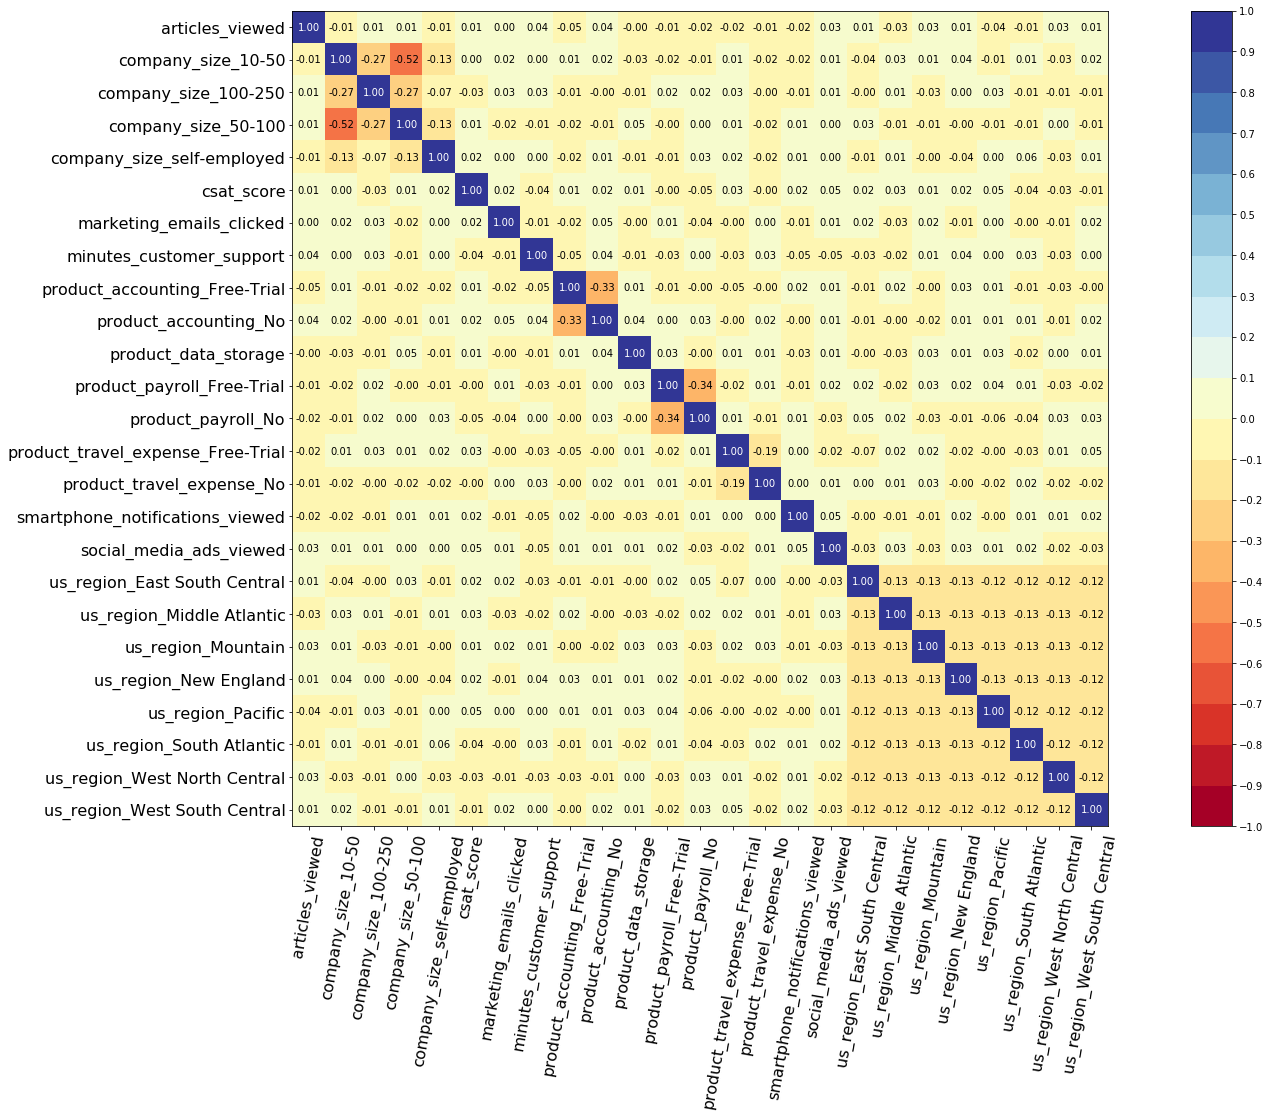

In [4]:
from pysurvival.utils.display import correlation_matrix
correlation_matrix(dataset[features], figure_size=(30,15), text_fontsize=10)

In [5]:
# Building training and testing sets
from sklearn.model_selection import train_test_split
index_train, index_test = train_test_split( range(N), test_size = 0.35)
data_train = dataset.loc[index_train].reset_index( drop = True )
data_test  = dataset.loc[index_test].reset_index( drop = True )

# Creating the X, T and E inputs
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]

In [6]:
from pysurvival.models.survival_forest import ConditionalSurvivalForestModel

# Fitting the model
csf = ConditionalSurvivalForestModel(num_trees=200)
csf.fit(X_train, T_train, E_train, max_features='sqrt',
        max_depth=5, min_node_size=20, alpha=0.05, minprop=0.1)

ConditionalSurvivalForestModel

In [7]:
# Computing variables importance
csf.variable_importance_table.head(5)

,feature,importance,pct_importance
0,csat_score,12.873045,0.194010
1,product_payroll_No,11.463105,0.172761
2,product_accounting_No,9.304154,0.140223
3,minutes_customer_support,8.372566,0.126183
4,product_travel_expense_Free-Trial,5.038761,0.075939


In [8]:
from pysurvival.utils.metrics import concordance_index
c_index = concordance_index(csf, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(c_index)) #0.83

C-index: 0.83


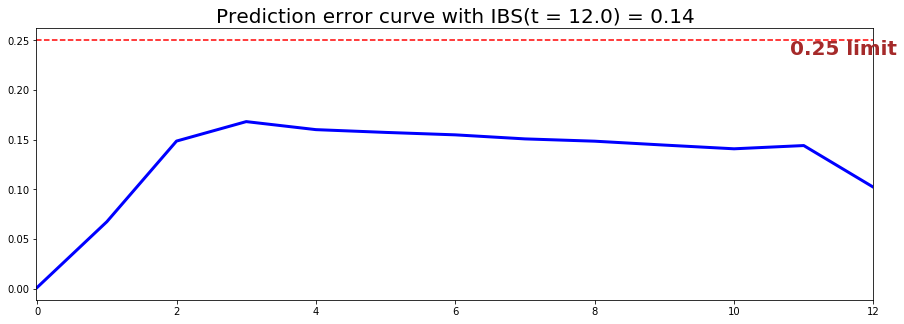

IBS: 0.14


In [9]:
from pysurvival.utils.display import integrated_brier_score
ibs = integrated_brier_score(csf, X_test, T_test, E_test, t_max=12,
    figure_size=(15,5))
print('IBS: {:.2f}'.format(ibs))

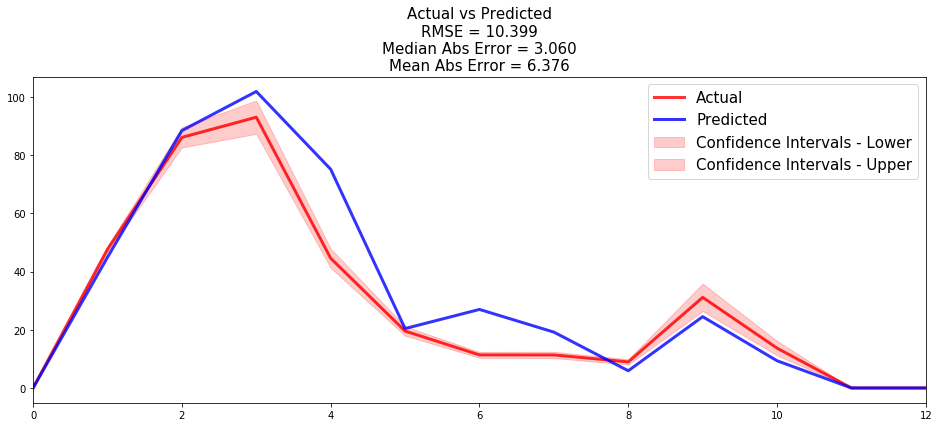

In [10]:
from pysurvival.utils.display import compare_to_actual
results = compare_to_actual(csf, X_test, T_test, E_test,
                            is_at_risk = False,  figure_size=(16, 6),
                            metrics = ['rmse', 'mean', 'median'])

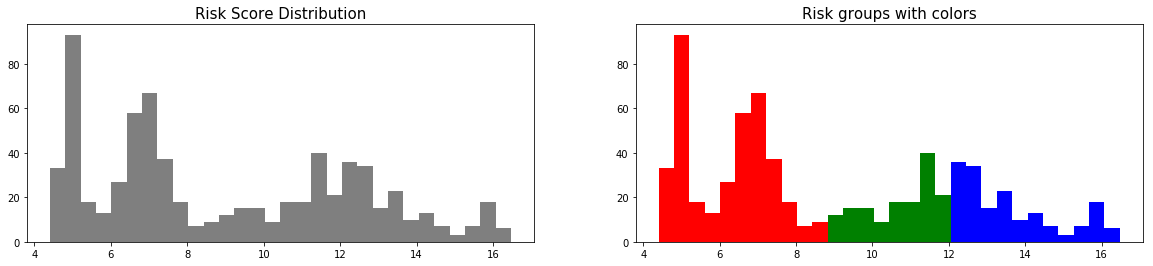

In [11]:
from pysurvival.utils.display import create_risk_groups

risk_groups = create_risk_groups(model=csf, X=X_test,
    use_log = False, num_bins=30, figure_size=(20, 4),
    low={'lower_bound':0, 'upper_bound':8.5, 'color':'red'},
    medium={'lower_bound':8.5, 'upper_bound':12.,'color':'green'},
    high={'lower_bound':12., 'upper_bound':25,  'color':'blue'}
    )